This notebook characterizes the dependence of sequence replay on specific model parameter combinations.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln


N_SEEDS = 10
MAX_SEED = 1000
DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5
RANK_CORR_CUTOFF = .9
SPD_DTCN_WDW = .2


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.083, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .8},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# Plot dynamics regimes results

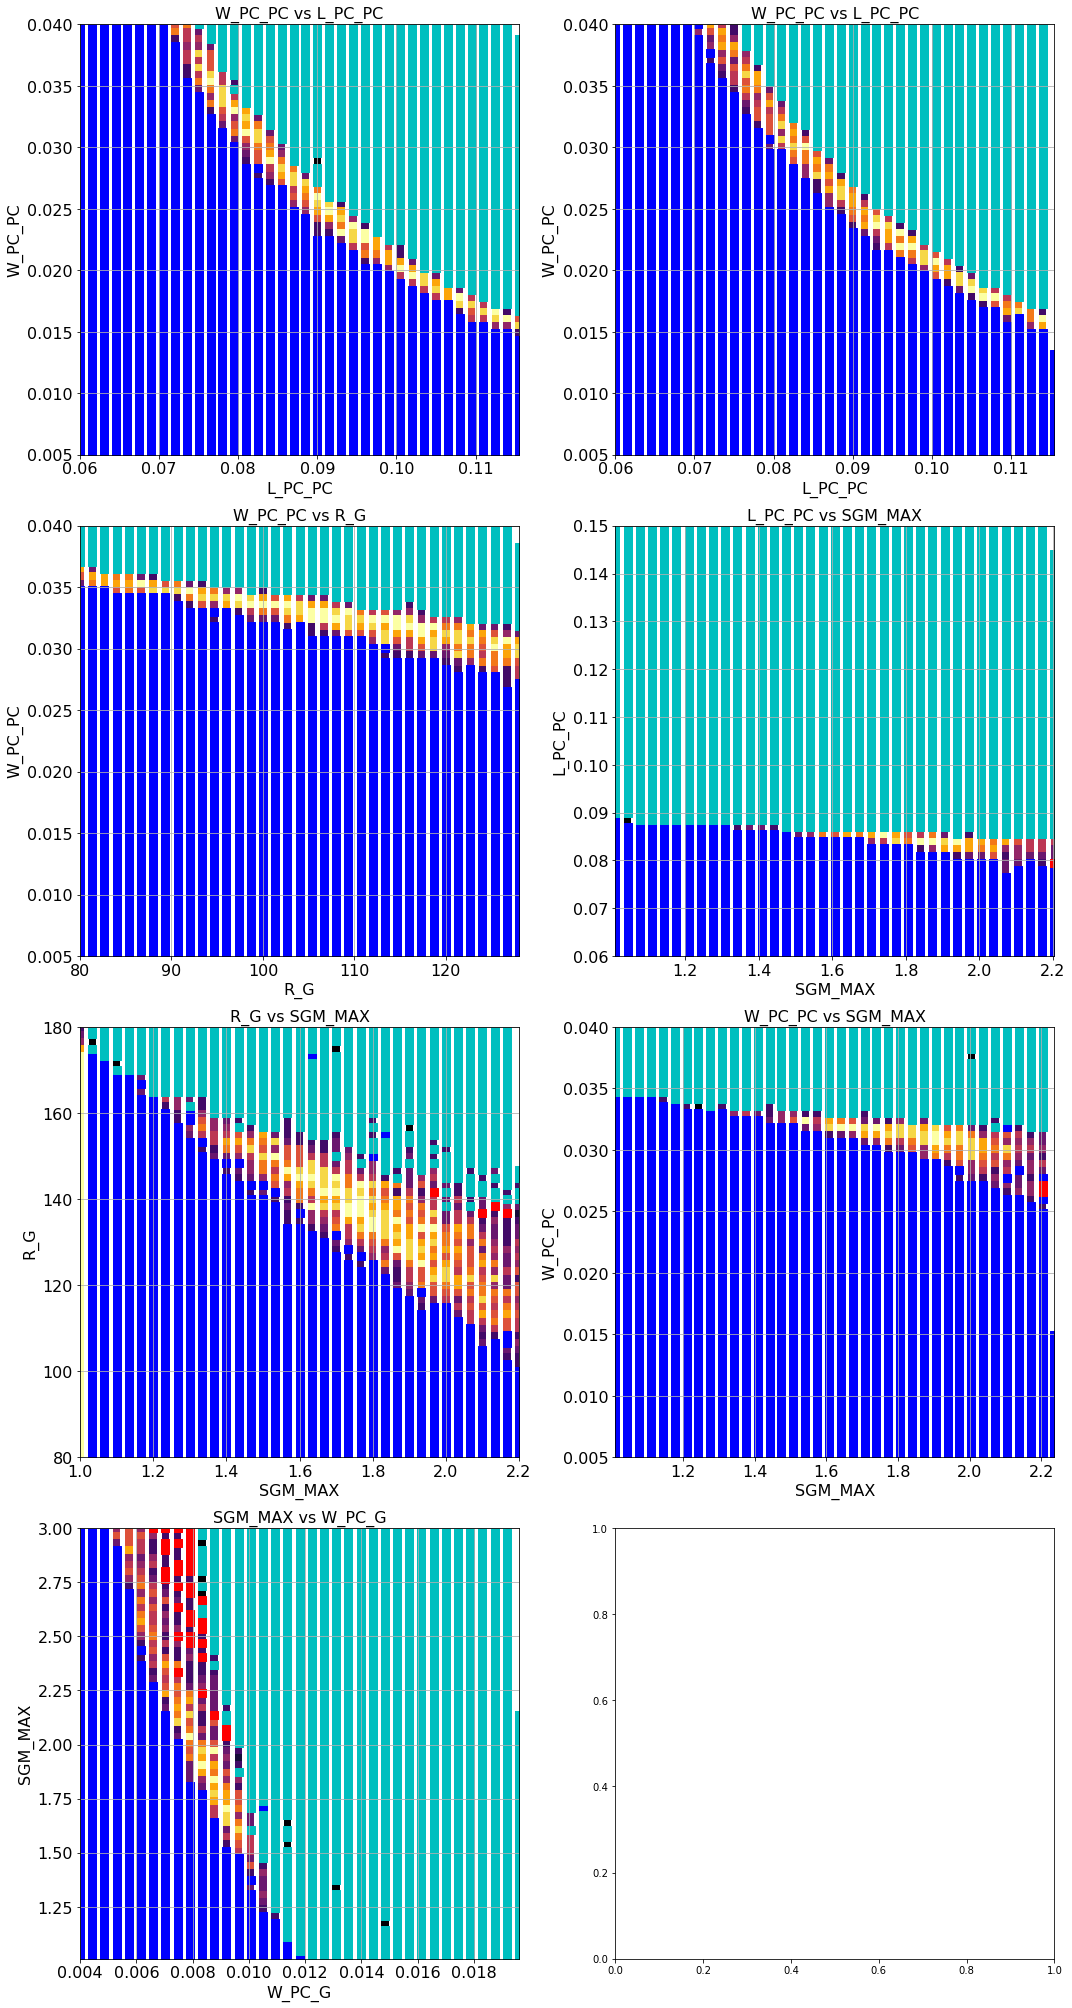

In [2]:
from ast import literal_eval

RSLT_FILES = [
    'replay_param_sweep_L_PC_PC_W_PC_PC_0.csv',
    'replay_param_sweep_L_PC_PC_W_PC_PC_1.csv',
    'replay_param_sweep_R_G_W_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_L_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_R_G_0.csv',
    'replay_param_sweep_SGM_MAX_W_PC_PC_0.csv',
    'replay_param_sweep_W_PC_G_SGM_MAX_0.csv',
]

m_paramss = []
s_paramss = []
cols = []
dfs = []

fig, axs = plt.subplots(4, 2, figsize=(15, 28), tight_layout=True)

for rslt_file, ax in zip(RSLT_FILES, axs.flatten()):
    
    with open(rslt_file, 'r') as f:
        m_params = literal_eval(f.readline().strip())
        s_params = literal_eval(f.readline().strip())

    df = pd.read_csv(rslt_file, header=2, index_col=0)

    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    ax.scatter(vals_x, vals_y, marker='s', s=55, c=n_replay, cmap='inferno', vmin=0, vmax=10, lw=0, zorder=0)
    
    # color non-replay units by fadeout vs blowup vs disordered
    df_fadeout = df[(n_replay < 2) & (df['N_FADEOUT'] > df['N_BLOWUP']) & (df['N_FADEOUT'] > df['N_DISORDERED'])]
    ax.scatter(df_fadeout[col_x], df_fadeout[col_y], marker='s', s=55, c='b', zorder=1)
    
    df_blowup = df[(n_replay < 2) & (df['N_BLOWUP'] > df['N_FADEOUT']) & (df['N_BLOWUP'] > df['N_DISORDERED'])]
    ax.scatter(df_blowup[col_x], df_blowup[col_y], marker='s', s=55, c='c', zorder=1)
    
    df_disordered = df[(n_replay < 2) & (df['N_DISORDERED'] > df['N_BLOWUP']) & (df['N_DISORDERED'] > df['N_FADEOUT'])]
    ax.scatter(df_disordered[col_x], df_disordered[col_y], marker='s', s=55, c='r', zorder=1)
    
    ax.set_xlim(vals_x.min(), vals_x.max())
    ax.set_ylim(vals_y.min(), vals_y.max())
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title('{} vs {}'.format(col_y, col_x))
    
    ax.grid()
    
    set_font_size(ax, 16)
    
    m_paramss.append(m_params)
    s_paramss.append(s_params)
    
    cols.append((col_x, col_y))
    
    dfs.append(df)

# Run param sweeps

## Define fadeout, blowup, disordered, and replay detection functions

In [3]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # check if fadeout or blowup
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    
    # check if replay is ordered or not
    ## get mask over spking trj cells
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    ## order nrns by place field location along trj
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    ### negative b/c trj is triggered to replay in reverse
    pf_order = -smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    ## order nrns by first spk times
    spk_order = rslt.spks[t_mask][:, trj_spk_mask].argmax(0)
    
    ## get correlation
    pf_spk_rank_corr = stats.spearmanr(pf_order, spk_order)[0]
    
    if pf_spk_rank_corr < RANK_CORR_CUTOFF:
        return 'disordered'
    else:
        return 'replay'

## Define replay speed evaluation function

In [4]:
def get_replay_speed(rslt, m_params, s_params):
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + SPD_DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    ts = start + (np.arange(t_mask.sum()) * s_params['DT'])
    
    # get mask over spking trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    # get int location along trj of spking PCs
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    pf_order = smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    # convert int loc along trj to dist along trj
    dx = np.diff(rslt.trj['x'])
    dy = np.diff(rslt.trj['y'])
    
    ds_trj = np.concatenate([[0], np.cumsum(np.sqrt(dx**2 + dy**2))])
    
    ds = ds_trj[pf_order]
    
    # make (t_spk, d) pairs for all trj spks in SPD_DTCN_WDW
    spk_t_idxs, spk_pc_idxs = rslt.spks[t_mask][:, trj_spk_mask].nonzero()

    ds_spk = ds[spk_pc_idxs]
    ts_spk = ts[spk_t_idxs]
    
    # fit line to ds_spk vs ts_spk
    rgr = linear_model.HuberRegressor().fit(ts_spk[:, None], ds_spk)
    spd = np.abs(rgr.coef_[0])
    
    return spd

## Define spontaneous trj activity evaluation function

## Test detection functions

### Fadeout

Running smln...
Smln complete.
RSP TYPE:  fadeout


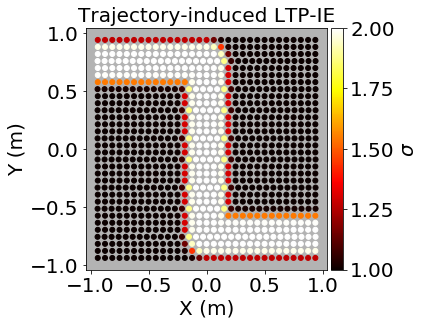

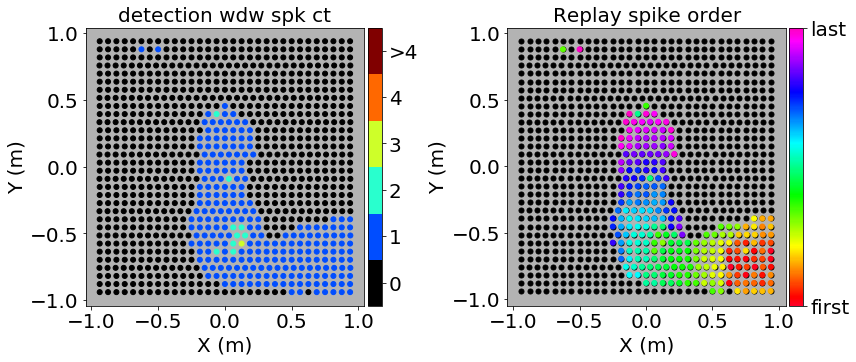

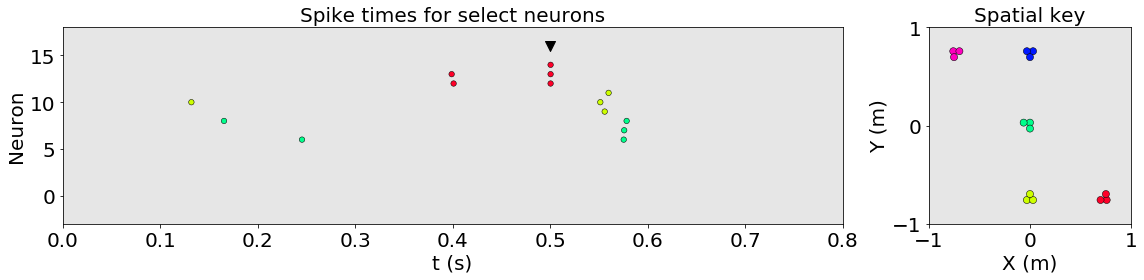

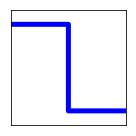

In [5]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .028
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Blowup

Running smln...
Smln complete.
RSP TYPE:  blowup


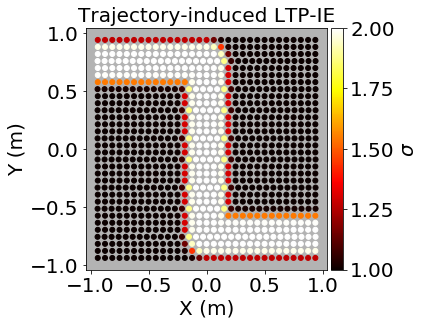

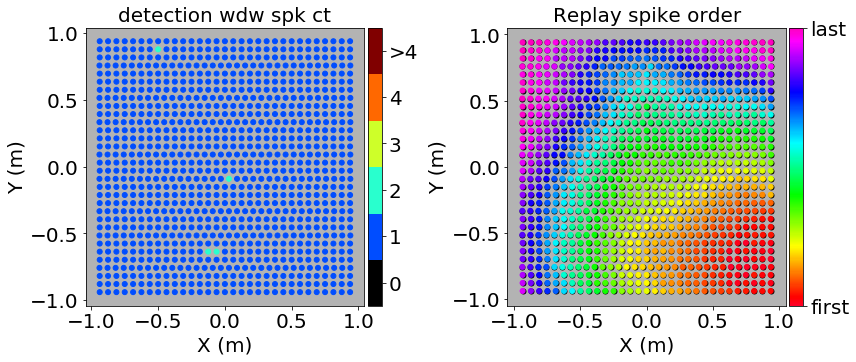

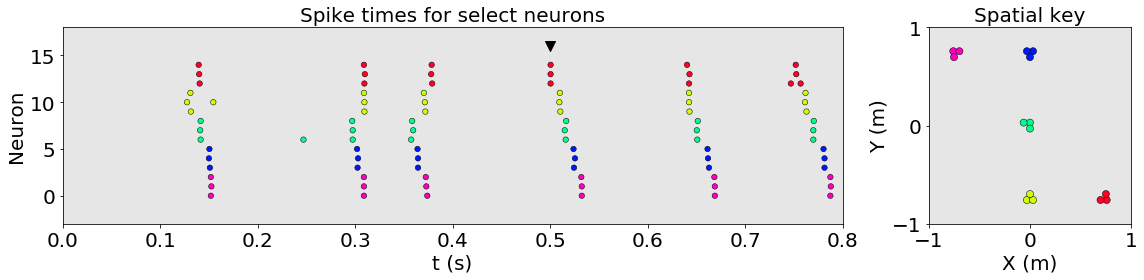

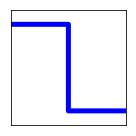

In [6]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .05
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Disordered

Running smln...
Smln complete.
RSP TYPE:  disordered


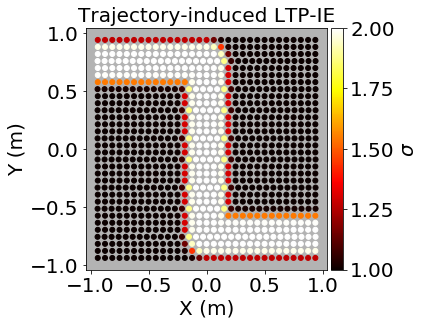

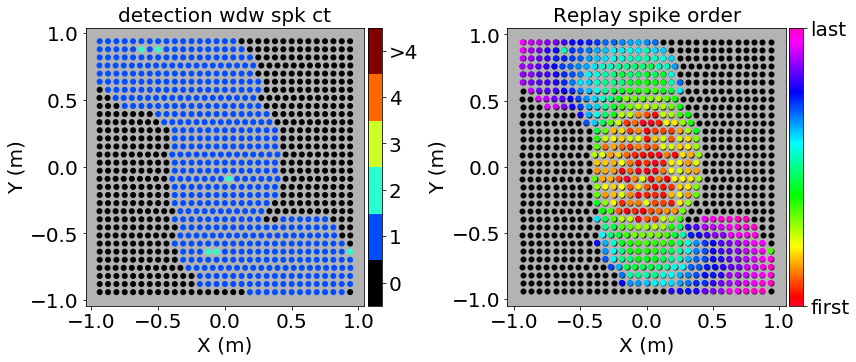

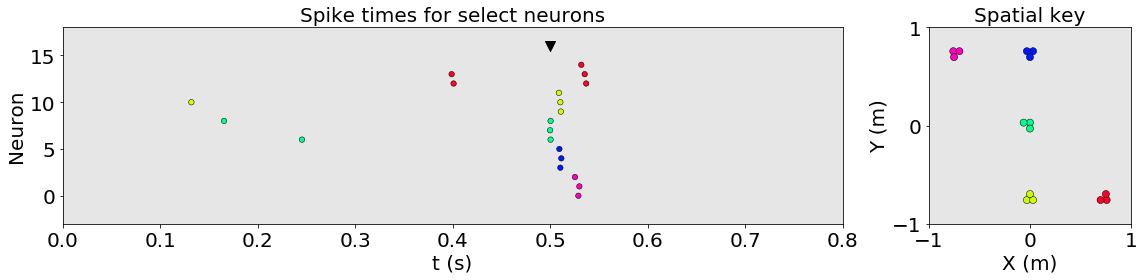

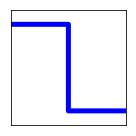

In [7]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['TRG'] = [{'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 0, 'Y': 0}]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

### Replay fast

Running smln...
Smln complete.
RSP TYPE:  replay
REPLAY SPEED:  45.035219866249015 m/s


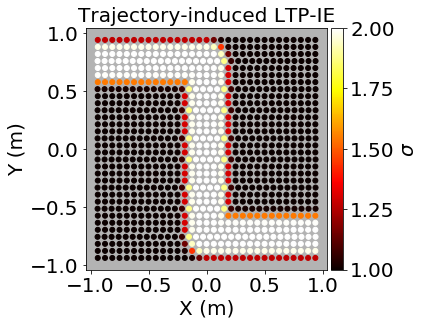

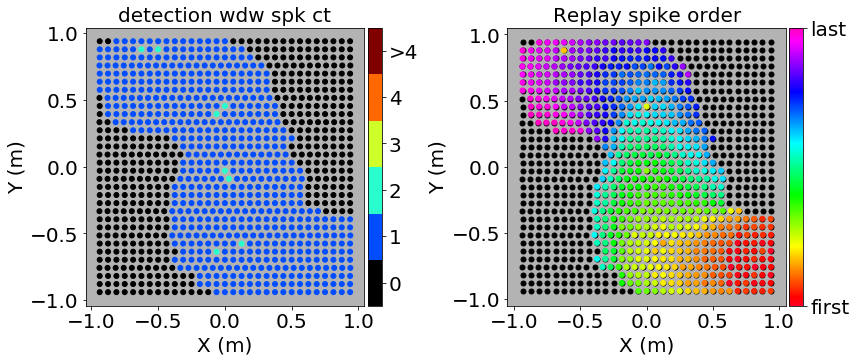

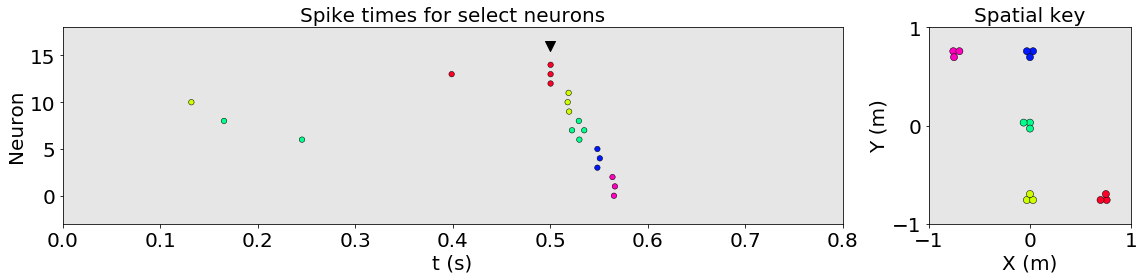

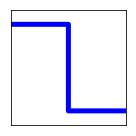

In [10]:
import pdb

def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.016
    m_params['L_PC_PC'] = 0.115
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('REPLAY SPEED: ', get_replay_speed(rslt, m_params, s_params), 'm/s')

test()

### Replay slow

Running smln...
Smln complete.
RSP TYPE:  replay
REPLAY SPEED:  31.716346851019356 m/s


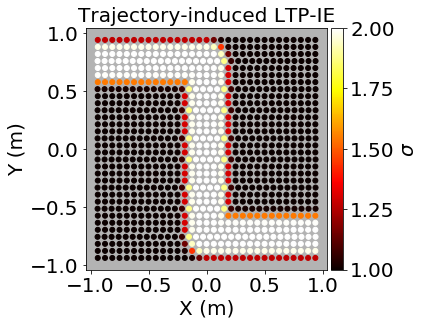

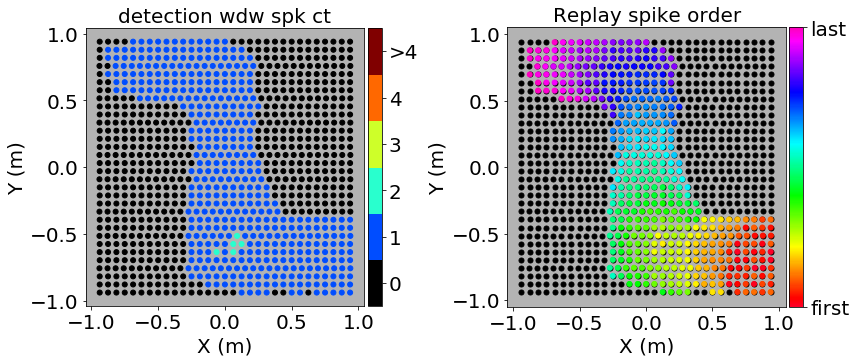

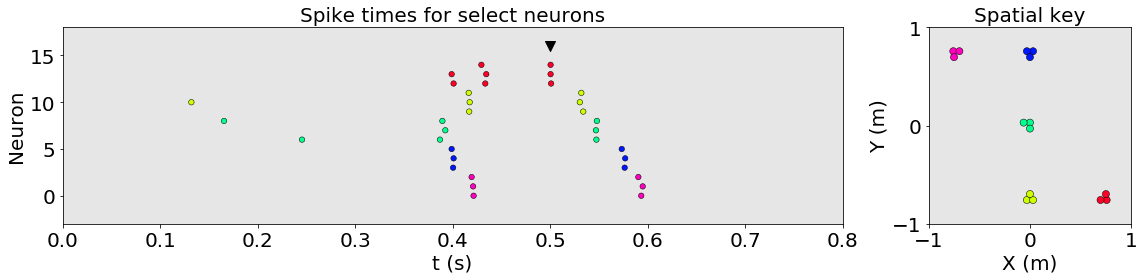

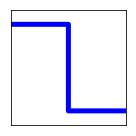

In [11]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    
    m_params['W_PC_PC'] = 0.0325
    m_params['L_PC_PC'] = 0.08
    
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('REPLAY SPEED: ', get_replay_speed(rslt, m_params, s_params), 'm/s')

test()

# Param sweeps